In [1]:
pip install Gpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 5.7 MB/s eta 0:00:00


Dimensione di y_pred_nn: (30, 1)


Mean Squared Error del Processo Gaussiano con kernel esponenziale: 433476397.76298195
Mean Squared Error del Processo Gaussiano con kernel esponenziale quadratico: 438668874.3042195


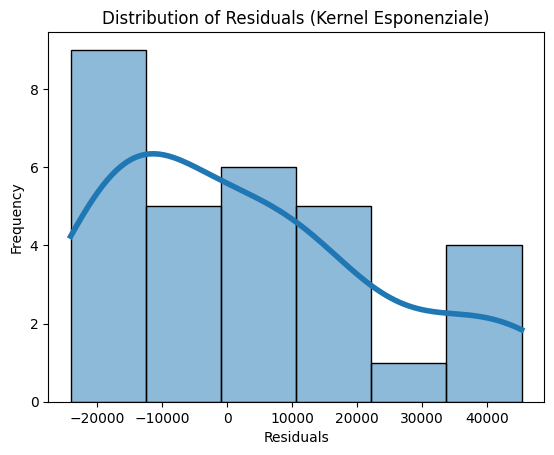

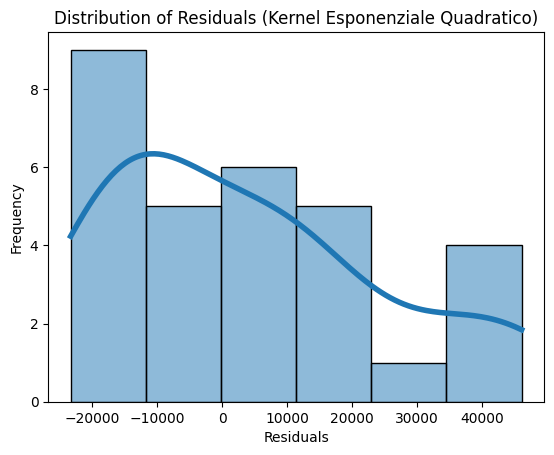

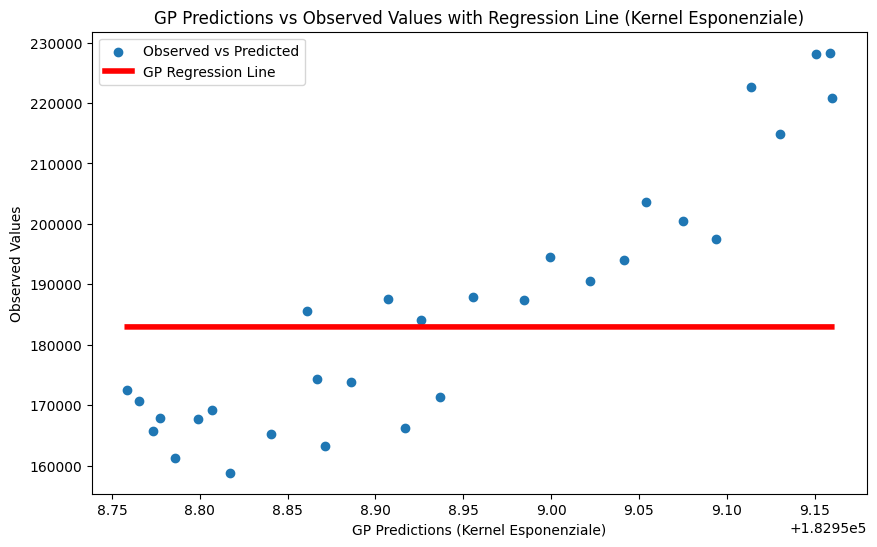

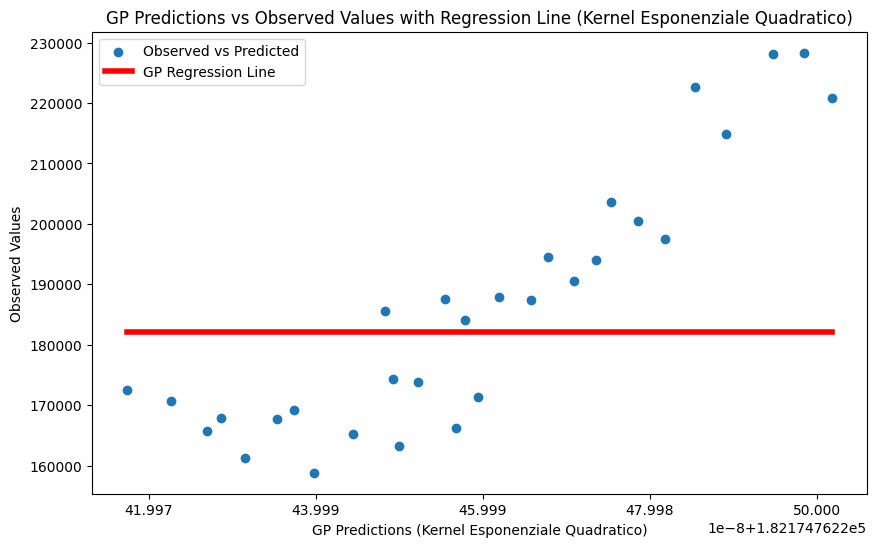

Mean Squared Error della regressione lineare sulle predizioni della rete neurale: 48607546.651381254
Coefficients of the linear regression model: [1.05593184]
Intercept of the linear regression model: -9927.899577241711


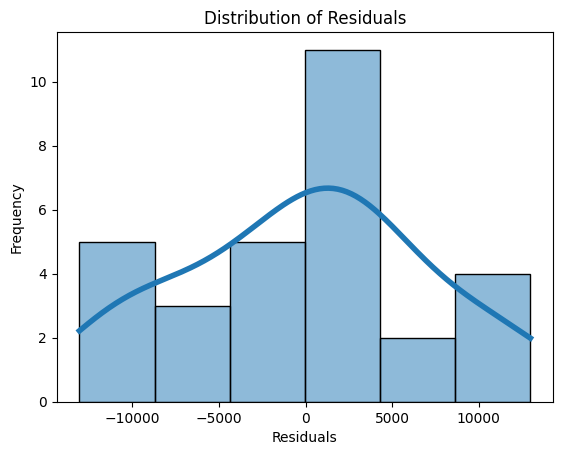

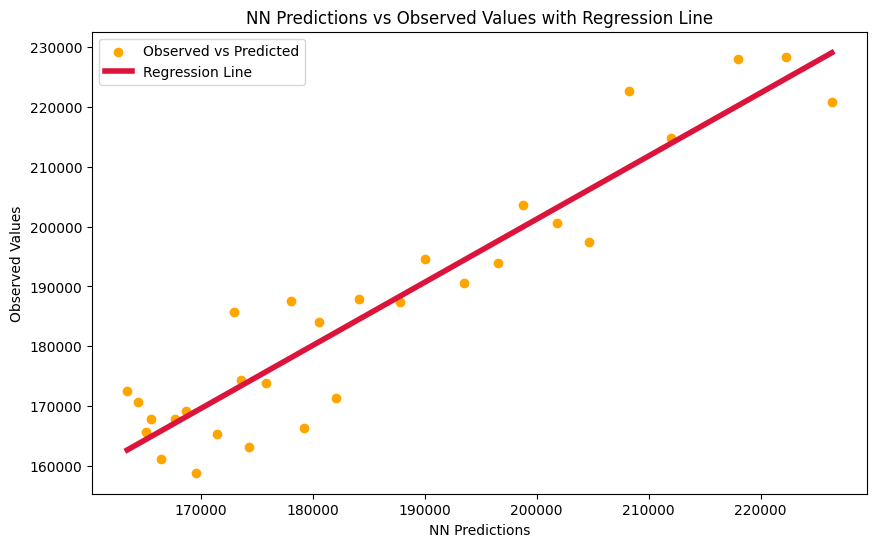

In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import GPy
from sklearn.linear_model import LinearRegression


def main():
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv')
    X = data[['CO2', 'CH4']].values
    y = data['Respiratory Diseases'].values

    plt.rcParams['lines.linewidth'] = 4

    # Normalizzazione dei dati
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_test=X_scaled
    y_test=y

    # Caricamento del file CSV con le predizioni della rete neurale
    predictions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MentalResp90-19.csv')
    y_pred_nn = predictions['Predicted Respiratory Diseases'].values.reshape(-1, 1)
    # Stampa di debug per le dimensioni delle predizioni
    print(f'Dimensione di y_pred_nn: {y_pred_nn.shape}')

    # Assicurati che y_pred_nn abbia la stessa dimensione di X_test
    assert len(y_pred_nn) == len(X_test), "Le dimensioni delle predizioni e dei dati di test non corrispondono!"

    # Utilizzo del Processo Gaussiano con kernel esponenziale
    kernel_exp = GPy.kern.Exponential(input_dim=2, variance=2., lengthscale=2.)
    gp_model_exp = GPy.models.GPRegression(X_test, y_pred_nn, kernel_exp)
    gp_model_exp.optimize(messages=True)

    # Utilizzo del Processo Gaussiano con kernel esponenziale quadratico
    kernel_rbf = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.)
    gp_model_rbf = GPy.models.GPRegression(X_test, y_pred_nn, kernel_rbf)
    gp_model_rbf.optimize(messages=True)

    # Predizione con il modello GP con kernel esponenziale
    y_pred_gp_exp, _ = gp_model_exp.predict(X_test)
    mse_gp_exp = mean_squared_error(y_test, y_pred_gp_exp)
    print(f'Mean Squared Error del Processo Gaussiano con kernel esponenziale: {mse_gp_exp}')

    # Predizione con il modello GP con kernel esponenziale quadratico
    y_pred_gp_rbf, _ = gp_model_rbf.predict(X_test)
    mse_gp_rbf = mean_squared_error(y_test, y_pred_gp_rbf)
    print(f'Mean Squared Error del Processo Gaussiano con kernel esponenziale quadratico: {mse_gp_rbf}')

    # Analisi dei residui per il kernel esponenziale
    residuals_exp = y_test - y_pred_gp_exp.flatten()
    sns.histplot(residuals_exp, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals (Kernel Esponenziale)')
    plt.show()

    # Analisi dei residui per il kernel esponenziale quadratico
    residuals_rbf = y_test - y_pred_gp_rbf.flatten()
    sns.histplot(residuals_rbf, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals (Kernel Esponenziale Quadratico)')
    plt.show()

    # Scatter plot delle predizioni del GP vs valori osservati per kernel esponenziale
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_gp_exp, y_test, label='Observed vs Predicted')
    plt.plot(y_pred_gp_exp, y_pred_gp_exp, color='red', label='GP Regression Line')
    plt.xlabel('GP Predictions (Kernel Esponenziale)')
    plt.ylabel('Observed Values')
    plt.title('GP Predictions vs Observed Values with Regression Line (Kernel Esponenziale)')
    plt.legend()
    plt.show()

    # Scatter plot delle predizioni del GP vs valori osservati per kernel esponenziale quadratico
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_gp_rbf, y_test, label='Observed vs Predicted')
    plt.plot(y_pred_gp_rbf, y_pred_gp_rbf, color='red', label='GP Regression Line')
    plt.xlabel('GP Predictions (Kernel Esponenziale Quadratico)')
    plt.ylabel('Observed Values')
    plt.title('GP Predictions vs Observed Values with Regression Line (Kernel Esponenziale Quadratico)')
    plt.legend()
    plt.show()

# Applicazione della regressione lineare sulle predizioni della rete neurale
    reg = LinearRegression()
    reg.fit(y_pred_nn.reshape(-1, 1), y_test)

# Valutazione del modello di regressione lineare
    y_pred_reg = reg.predict(y_pred_nn.reshape(-1, 1))
    mse = mean_squared_error(y_test, y_pred_reg)
    print(f'Mean Squared Error della regressione lineare sulle predizioni della rete neurale: {mse}')
    print('Coefficients of the linear regression model:', reg.coef_)
    print('Intercept of the linear regression model:', reg.intercept_)

    colors=['crimson','forestgreen','royalblue','orange','red']

    # Analisi dei residui
    residuals = y_test - y_pred_reg
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.show()

    # Scatter plot delle predizioni della rete neurale vs valori osservati
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_nn, y_test, label='Observed vs Predicted',color='orange')
    plt.plot(y_pred_nn, y_pred_reg, color='crimson', label='Regression Line')
    plt.xlabel('NN Predictions')
    plt.ylabel('Observed Values')
    plt.title('NN Predictions vs Observed Values with Regression Line')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()